In [13]:
import pandas as pd
df = pd.read_csv('MergedData.csv')


In [14]:
features = [
    # --- WEATHER ---
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "surface_pressure",
    "precipitation",

    # --- WEATHER LAG 1 ---
    "temperature_2m_lag1",
    "humidity_2m_lag1",
    "wind_speed_10m_lag1",
    "surface_pressure_lag1",
    "precipitation_lag1",

    # --- WEATHER LAG 7 ---
    "temperature_2m_lag7",
    "humidity_2m_lag7",
    "wind_speed_10m_lag7",
    "surface_pressure_lag7",
    "precipitation_lag7",

    # --- WEATHER MA7 ---
    "temperature_2m_ma7",
    "humidity_2m_ma7",
    "wind_speed_10m_ma7",
    "surface_pressure_ma7",
    "precipitation_ma7",

    # --- WEATHER MA14 ---
    "temperature_2m_ma14",
    "humidity_2m_ma14",
    "wind_speed_10m_ma14",
    "surface_pressure_ma14",
    "precipitation_ma14",

    # --- SEASONALITY ---
    "sin_doy",
    "cos_doy"
]

target = "pm2_5"

In [15]:
import numpy as np

X = df[features].values
y = df[target].values

holdout_n = max(1, int(0.1 * len(df)))
X_trainval, X_hold = X[:-holdout_n], X[-holdout_n:]
y_trainval, y_hold = y[:-holdout_n], y[-holdout_n:]

print("Train+CV rows:", len(X_trainval), "Holdout rows:", len(X_hold))


Train+CV rows: 1089 Holdout rows: 121


In [16]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

tscv = TimeSeriesSplit(n_splits=3)
train_idx, val_idx = list(tscv.split(X_trainval))[-1]  # last fold

X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
y_tr, y_val = y_trainval[train_idx], y_trainval[val_idx]

model1 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    verbosity=1,
    early_stopping_rounds=50,
)

model1.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    
    verbose=True,
)

pred_val = model1.predict(X_val)
print("Fold VAL MAE:", mean_absolute_error(y_val, pred_val))
print("Fold VAL RMSE:", root_mean_squared_error(y_val, pred_val))


[0]	validation_0-rmse:13.98149
[1]	validation_0-rmse:13.74940
[2]	validation_0-rmse:13.53499
[3]	validation_0-rmse:13.33490
[4]	validation_0-rmse:13.14033
[5]	validation_0-rmse:12.95304
[6]	validation_0-rmse:12.77603
[7]	validation_0-rmse:12.58865
[8]	validation_0-rmse:12.41930
[9]	validation_0-rmse:12.28896
[10]	validation_0-rmse:12.13175
[11]	validation_0-rmse:11.96363
[12]	validation_0-rmse:11.82904
[13]	validation_0-rmse:11.70187
[14]	validation_0-rmse:11.56281
[15]	validation_0-rmse:11.43012
[16]	validation_0-rmse:11.30939
[17]	validation_0-rmse:11.18497
[18]	validation_0-rmse:11.08462
[19]	validation_0-rmse:10.99291
[20]	validation_0-rmse:10.90807
[21]	validation_0-rmse:10.80547
[22]	validation_0-rmse:10.70350
[23]	validation_0-rmse:10.60927
[24]	validation_0-rmse:10.49899
[25]	validation_0-rmse:10.42146
[26]	validation_0-rmse:10.33649
[27]	validation_0-rmse:10.25483
[28]	validation_0-rmse:10.17610
[29]	validation_0-rmse:10.09525
[30]	validation_0-rmse:10.01080
[31]	validation_0-

In [17]:
tscv = TimeSeriesSplit(n_splits=5)
maes, rmses = [], []

for i, (tr_idx, vl_idx) in enumerate(tscv.split(X_trainval), 1):
    X_tr, X_val = X_trainval[tr_idx], X_trainval[vl_idx]
    y_tr, y_val = y_trainval[tr_idx], y_trainval[vl_idx]

    m = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0,
         early_stopping_rounds=50,
    )

    m.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
       
        verbose=False,
    )

    p = m.predict(X_val)
    mae = mean_absolute_error(y_val, p)
    rmse = root_mean_squared_error(y_val, p)
    maes.append(mae)
    rmses.append(rmse)
    print(f"Fold {i}: MAE={mae:.4f}, RMSE={rmse:.4f}, best_iter={m.best_iteration}")

print("Model 1 CV MAE mean ± std:", np.mean(maes), np.std(maes))
print("Model 1 CV RMSE mean ± std:", np.mean(rmses), np.std(rmses))


Fold 1: MAE=5.3062, RMSE=6.6876, best_iter=240
Fold 2: MAE=7.3620, RMSE=8.9080, best_iter=115
Fold 3: MAE=4.6015, RMSE=5.6503, best_iter=85
Fold 4: MAE=6.5349, RMSE=8.9989, best_iter=491
Fold 5: MAE=4.6204, RMSE=6.3395, best_iter=117
Model 1 CV MAE mean ± std: 5.68501322988647 1.0941215475690336
Model 1 CV RMSE mean ± std: 7.316850357663936 1.3776269893039603


In [18]:
final_m1 = XGBRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    objective="reg:squarederror",
    random_state=42,
    verbosity=1,
    early_stopping_rounds=50,
)

final_m1.fit(
    X_trainval,
    y_trainval,
    eval_set=[(X_hold, y_hold)],
   
    verbose=True,
)

pred_hold_m1 = final_m1.predict(X_hold)

m1_mae = mean_absolute_error(y_hold, pred_hold_m1)
m1_rmse = root_mean_squared_error(y_hold, pred_hold_m1)
print("Model 1 Holdout MAE:", m1_mae)
print("Model 1 Holdout RMSE:", m1_rmse)


[0]	validation_0-rmse:12.98310
[1]	validation_0-rmse:12.90864
[2]	validation_0-rmse:12.82825
[3]	validation_0-rmse:12.75474
[4]	validation_0-rmse:12.69747
[5]	validation_0-rmse:12.62209
[6]	validation_0-rmse:12.57459
[7]	validation_0-rmse:12.50578
[8]	validation_0-rmse:12.43542
[9]	validation_0-rmse:12.36827
[10]	validation_0-rmse:12.30833
[11]	validation_0-rmse:12.24337
[12]	validation_0-rmse:12.18777
[13]	validation_0-rmse:12.12473
[14]	validation_0-rmse:12.05511
[15]	validation_0-rmse:11.98702
[16]	validation_0-rmse:11.93484
[17]	validation_0-rmse:11.87389
[18]	validation_0-rmse:11.81075
[19]	validation_0-rmse:11.76261
[20]	validation_0-rmse:11.70194
[21]	validation_0-rmse:11.65223
[22]	validation_0-rmse:11.60437
[23]	validation_0-rmse:11.55167
[24]	validation_0-rmse:11.49109
[25]	validation_0-rmse:11.43065
[26]	validation_0-rmse:11.36600
[27]	validation_0-rmse:11.30644
[28]	validation_0-rmse:11.26281
[29]	validation_0-rmse:11.19879
[30]	validation_0-rmse:11.15296
[31]	validation_0-

In [19]:
final_m1.save_model("model1_xgb.json")
print("Model 1 saved as model1_xgb.json")


Model 1 saved as model1_xgb.json


In [20]:
import xgboost as xgb
m = xgb.XGBRegressor()
m.load_model("model1_xgb.json")

In [21]:
p = m.predict(X_hold)
print(mean_absolute_error(y_hold, p))
print(root_mean_squared_error(y_hold, p))

4.3677289954886955
5.8316897315972085


In [22]:
row = df.loc[650]
x = row[features].values.reshape(1, -1)
pred = m.predict(x)
print(pred)
print(row[target])

[14.2389145]
14.4


In [23]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("Model 1 MAE:", mean_absolute_error(y_hold, p))
print("Model 1 RMSE:", root_mean_squared_error(y_hold, p))

Model 1 MAE: 4.3677289954886955
Model 1 RMSE: 5.8316897315972085


In [24]:
compare = pd.DataFrame({
    "date": df["date"].iloc[-len(y_hold):].values,
    "actual": y_hold,
    "model1_pred": p,})
compare["model1_abs_error"] = (compare["actual"] - compare["model1_pred"]).abs()
compare

,date,actual,model1_pred,model1_abs_error
0,10-08-2025,11.0,13.907469,2.907469
1,11-08-2025,8.9,10.879426,1.979426
2,12-08-2025,7.5,7.999948,0.499948
3,13-08-2025,5.3,6.239213,0.939213
4,14-08-2025,4.5,8.051315,3.551315
...,...,...,...,...
116,04-12-2025,8.2,15.154672,6.954672
117,05-12-2025,32.3,14.352816,17.947184
118,06-12-2025,45.3,23.833118,21.466882
119,07-12-2025,40.3,31.962694,8.337306


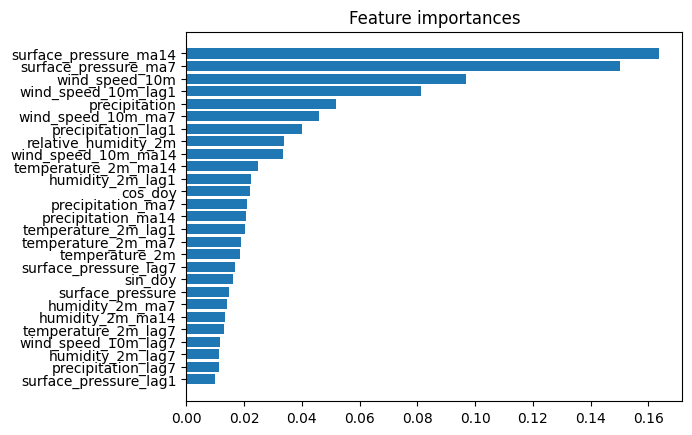

In [25]:
import numpy as np
import matplotlib.pyplot as plt

importances = final_m1.feature_importances_
idx = np.argsort(importances)[::-1]
plt.barh(np.array(features)[idx], importances[idx])
plt.gca().invert_yaxis()
plt.title("Feature importances")
plt.show()
